In [11]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

In [12]:
data_path = 'bike-sharing/hour.csv'  #读取数据到内存，rides为一个dataframe对象
rides = pd.read_csv(data_path)

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday'] #所有类型编码变量的名称
for each in dummy_fields:
    #取出所有类型变量，并将它们转变为独热编码
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    #将新的独热编码变量与原有的所有变量合并到一起
    rides = pd.concat([rides, dummies], axis=1)

#将原来的类型变量从数据表中删除
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 
    'hr'] #要删除的类型变量的名称
data = rides.drop(fields_to_drop, axis=1) #将它们从数据库的变量中删除

data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0.26,0.60,0.1642,11,108,119,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,0.26,0.60,0.1642,8,81,89,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,0.26,0.60,0.1642,7,83,90,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,0.26,0.56,0.1343,13,48,61,1,0,...,0,1,0,0,1,0,0,0,0,0


In [13]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed'] #数值类型变量的名称
scaled_features = {}  #将每一个变量的均值和方差都存储到scaled_features变量中
means, stds = list(),list()
for each in quant_features:
    #计算这些变量的均值和方差
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    #对每一个变量进行归一化
    data.loc[:, each] = (data[each] - mean)/std
    means.append(mean)
    stds.append(std)
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,3,13,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,8,32,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,5,27,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,3,10,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,0,1,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,-1.230743,-0.141133,-0.211685,11,108,-0.388467,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,-1.230743,-0.141133,-0.211685,8,81,-0.553859,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,-1.230743,-0.141133,-0.211685,7,83,-0.548346,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,-1.230743,-0.348463,-0.456086,13,48,-0.708224,1,0,...,0,1,0,0,1,0,0,0,0,0


In [14]:
#将最后一个月的数据作为测试集
test_data = data[-30*24:] #选出训练集
train_data = data[:-30*24] #选出测试集

#目标列包含的字段
target_fields = ['cnt','casual', 'registered'] 

#训练集划分成特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

#测试集划分成特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]



In [15]:
X = features.values  #将数据从pandas dataframe转换为NumPy
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1]) #把结果集转为一个个list

调参刚开始的时候，一般要先初始化一些值：

1，选择较高的学习速率（learning rate）。一般情况下，学习速率的值为0.1。但是对于不同的问题，理想的学习速率有时候会在0.05到0.3之间波动。选择对应于此学习速率的理想决策树数量。 Xgboost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。

2，对于给定的学习速率和决策树数量，进行决策树特定参数调优（max_depth，min_child_weight，gamma，subsample，colsample_bytree）。在确定一棵树的过程中，我们可以选择不同的参数。

3，Xgboost的正则化参数的调优。（lambda，alpha）。这些参数可以降低模型的复杂度，从而提高模型的表现。

4，降低学习速率，确定理想参数。

In [10]:
from sklearn.model_selection import GridSearchCV

param_test1 = {

'n_estimators':range(20,300,20)

}
gsearch1 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.5,max_depth=5,

min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,

nthread=4,scale_pos_weight=1,seed=27,),

param_grid=param_test1,cv=5)

gsearch1.fit(features, targets)

print(gsearch1.best_params_, gsearch1.best_score_)

KeyboardInterrupt: 

In [6]:
param_test2 = {

'max_depth':range(3,10,2),

'min_child_weight':range(1,6,2)

}

gsearch2 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1,n_estimators=140),

param_grid=param_test2)

gsearch2.fit(features, targets)

print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 9, 'min_child_weight': 3} 0.8105770833202485


In [7]:
param_test4 = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}
gsearch4 = GridSearchCV(estimator=XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=9, min_child_weight=3),
                        param_grid=param_test4)
gsearch4.fit(features, targets)
print(gsearch4.best_params_, gsearch4.best_score_)

{'gamma': 0.0} 0.8105770833202485


In [8]:
param_test5 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)]
}
gsearch5 = GridSearchCV(
    estimator=XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=9, min_child_weight=3, gamma=0.0),
    param_grid=param_test5)
gsearch5.fit(features, targets)
print(gsearch5.best_params_, gsearch5.best_score_)

{'colsample_bytree': 0.7, 'subsample': 0.8} 0.8257863840100594


In [18]:
param_test6 = {
    'reg_alpha': [3, 4,5],
    'reg_lambda': [3, 4,5]
}
gsearch6 = GridSearchCV(
    estimator=XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=9, min_child_weight=3, gamma=0.0,
                           colsample_bytree=0.7, subsample=0.8),
    param_grid=param_test6)
gsearch6.fit(features, targets)
print(gsearch6.best_params_, gsearch6.best_score_)

{'reg_alpha': 3, 'reg_lambda': 5} 0.8324445506852864


In [20]:
#{'reg_alpha': 3, 'reg_lambda': 3} 0.831386790151741
# {'reg_alpha': 3, 'reg_lambda': 5} 0.8324445506852864
parmas_test7 = {
    'learning_rate': [0.05,0.1,0.15,0.2,0.25,0.3,0.5]
}

gsearch7 = GridSearchCV(
    estimator=XGBRegressor(n_estimators=140, max_depth=9, min_child_weight=3, gamma=0.0,
                            colsample_bytree=0.7, subsample=0.8,reg_alpha=3,reg_lambda=5),
    param_grid=parmas_test7)
gsearch7.fit(features, targets)
print(gsearch7.best_params_, gsearch7.best_score_)

{'learning_rate': 0.1} 0.8324445506852864


In [16]:
reg = XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=9, min_child_weight=3, gamma=0.0,
                            colsample_bytree=0.7, subsample=0.8,reg_alpha=3,reg_lambda=5)
        
reg.fit(features,targets)
y_pred = reg.predict(test_features)

# 输出预测结果至my_XGB_prediction.csv
# rides['y'] = y_pred
# rides.to_csv('output/my_XGB_tc2_prediction.csv', index=False)

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(test_targets, y_pred)
evs = explained_variance_score(test_targets, y_pred)
print("\n#### xgboost的表现 ####")
print('平均绝对误差:',mean_absolute_error(test_targets, y_pred))
print("均方误差:", round(mse, 2))
print("解释方差分:", round(evs, 2))
print("R方值(R2_score)",r2_score(test_targets,y_pred))

print("分类模型分数",reg.score(features,targets))


#### xgboost的表现 ####
平均绝对误差: 18.54701268366119
均方误差: 1524.93
解释方差分: 0.78
R方值(R2_score) 0.7693235724807003
分类模型分数 0.9611542090343841


In [23]:
targets = test_targets['cnt']  #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1])  #将数据转换成合适的tensor形式
#转为实数
targets = targets.astype(float)  



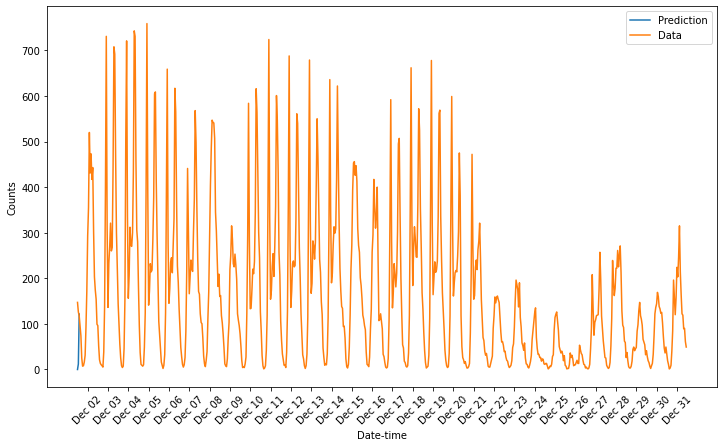

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 7))
mean, std = scaled_features['cnt']
ax.plot(y_pred , label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
fig.savefig('output/decisionTreeResult.svg',format='svg',dpi=150)

In [1]:
import numpy as np
print(np.sqrt(1472.4))

38.371864692766756



##### xgboost第一轮的表现
平均绝对误差: 16.928750542804494
均方误差: 1472.4
解释方差分: 0.78
R方值(R2_score) 0.7571025153986238
分类模型分数 0.9569351196861668

#### xgboost第二轮的表现 ####
平均绝对误差: 33.21146751664734
均方根误差: 2937.15
解释方差分: 0.79
R方值(R2_score) 0.7714128691971555
分类模型分数 0.9668982910077654